<a href="https://colab.research.google.com/github/ZiyanLi01/LMMM-demo/blob/main/Liz_LMMM_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# First would be to install lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-fp3lmhf9
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-fp3lmhf9
  Resolved https://github.com/google/lightweight_mmm.git to commit 78d9b0a81c8fbaeea0695af6d15ccd1cee8c6204
  Preparing metadata (setup.py) ... done


In [2]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import datetime
import numpy as np
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [3]:
pip install mysql.connector

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 82.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247948 sha256=262bf5831111fa7d1ac238a8c9e98485ae5013298a551fe06c2688c27ad2364d
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector


In [4]:
# @title ## Data Inputs

tenant_id = 133857     # @param {type: "integer"}
# start_date choose the first day with sales data
start_date = '2024-04-15'     # @param {type: "string"}
end_date_diff = 2    # @param {type: "integer"}
test_days = 14 # @param {type: "integer"}


import mysql.connector
import pandas as pd

# mydb = mysql.connector.connect(
#   host="",
#   user="vincentyu",
#   password="",
#   database="platform_offline"
# )

In [ ]:
# @title ## Query Data from DB
# please skip this part, becasuse we didn't have to connect to the database. I provide the experimental data below for demo purpose.


def fetch_mmm_data(tenant_id, start_date, end_date_diff, mydb):

  # ad spend by date, ads_platform, campaign_type
  query_ads = f"""

  select stat_date, ads_platform, campaign_type, sum(ad_spend)/7.78 sum_ad_spend, sum(impressions) sum_impressions
  from dwd_view_analytics_ads_ad_level_metrics_latest
  where tenant_id = {tenant_id}
  and stat_date >= '{start_date}'
  and stat_date <= date_sub(CURDATE(), interval {end_date_diff} day)
  and campaign_type not in ('MULTI_CHANNEL', 'OUTCOME_APP_PROMOTION', 'ENGAGEMENT', 'TRAFFIC', 'WEB_CONVERSIONS')
  group by 1,2, 3
  order by 1 asc

  """

  # Total shopify sales by date
  query_sales = f"""

  select event_date stat_date, sum(total_sales) sum_sales
  from ads_view_overview_sales_and_profit_latest
  where tenant_id = {tenant_id}
  and sales_platform = 'shopify'
  and event_date >= '{start_date}'
  and event_date <= date_sub(CURDATE(), interval {end_date_diff} day)
  group by 1


  """

  # pv by channel, date
  query_pv = f"""

  select event_date stat_date,
      SUM(CASE WHEN src_channel = '3rd_party' THEN attr_page_views ELSE 0 END)  AS third_party_pv,
      SUM(CASE WHEN src_channel = 'email' THEN attr_page_views ELSE 0 END) AS email_pv,
      SUM(CASE WHEN src_channel = 'organic_search' THEN attr_page_views ELSE 0 END) AS organic_search_pv,
      SUM(CASE WHEN src_channel = 'social' THEN attr_page_views ELSE 0 END) AS social_pv,
      SUM(CASE WHEN src_channel = 'shopify_app' THEN attr_page_views ELSE 0 END) AS shopify_app_pv,
      SUM(CASE WHEN src_channel = 'direct' THEN attr_page_views ELSE 0 END) AS direct_pv
  from dws_view_analytics_attribution_channel_level_latest
  where tenant_id = {tenant_id}
  and attr_enhanced in (1,4)
  and event_date >= '{start_date}'
  and event_date <= date_sub(CURDATE(), interval {end_date_diff} day)
  and json_overlaps(attr_model_array, json_array(0, 4))
  group by event_date


  """


  query_mmm = f"""

  select distinct ads_platform, campaign_type
  from dwd_view_analytics_ads_ad_level_metrics_latest
  where tenant_id = {tenant_id}
  and stat_date >= '{start_date}'
  and stat_date <= date_sub(CURDATE(), interval {end_date_diff} day)
  and ads_sales > 0
  order by 1 desc

  """


  df_mmm = pd.read_sql_query(query_mmm, mydb)

  # aov by campaign_type, platform
  final_df_aov = pd.DataFrame()


  for idx, row in df_mmm.iterrows():
      ads_platform = row['ads_platform']
      campaign_type = row['campaign_type']
      print(ads_platform, campaign_type)

      query_aov = f"""

        select event_date stat_date,
        sum(case when ads_platform = '{ads_platform}' and campaign_type = '{campaign_type}' then ads_sales else 0 end)/sum(case when ads_platform = '{ads_platform}' and campaign_type = '{campaign_type}' then ads_orders else 0 end) as {ads_platform}_{campaign_type}_aov,
        ifnull(sum(case when ads_platform = '{ads_platform}' and campaign_type = '{campaign_type}' then attr_sales else 0 end),0) {ads_platform}_{campaign_type}_attr_sales
        from dws_view_analytics_ads_ad_level_metrics_attrs_settings_latest
        where tenant_id = {tenant_id}
        and json_overlaps(attr_model_array, json_array(0, 32))
        and attr_enhanced in (1,4)
        and event_date >= '{start_date}'
        and event_date <= date_sub(CURDATE(), interval {end_date_diff} day)
        group by event_date
        order by 1 desc

      """
      df_aov = pd.read_sql_query(query_aov, mydb)

      if final_df_aov.empty:
          final_df_aov = df_aov
      else:
          final_df_aov = final_df_aov.merge(df_aov, on='stat_date', how='left')

  # attr orders by campaign_type, platform
  final_df_attr = pd.DataFrame()


  #final_df_aov = final_df_aov.dropna(axis=1, how='any')

  df_ads = pd.read_sql_query(query_ads, mydb)
  df_sales = pd.read_sql_query(query_sales, mydb)
  df_pv = pd.read_sql_query(query_pv, mydb)
  return df_ads, df_sales, df_pv, final_df_aov

df_ads, df_sales, df_pv, final_df_aov = fetch_mmm_data(tenant_id, start_date, end_date_diff, mydb)




NameError: name 'mydb' is not defined

In [5]:
from google.colab import files

# Upload files
uploaded = files.upload()

# Load files into DataFrames
df_ads = pd.read_csv("df_ads.csv")
df_sales = pd.read_csv("df_sales.csv")
df_pv = pd.read_csv("df_pv.csv")
final_df_aov = pd.read_csv("final_df_aov.csv")

Saving df_ads.csv to df_ads.csv
Saving df_pv.csv to df_pv.csv
Saving df_sales.csv to df_sales.csv
Saving final_df_aov.csv to final_df_aov.csv


In [6]:
df_ads['channel'] = df_ads['ads_platform'] + '_'+ df_ads['campaign_type']

df_media = df_ads.pivot(index = 'stat_date', columns = 'channel', values = 'sum_ad_spend').reset_index()
df_media = df_media.add_suffix('_spend')
df_media = df_media.rename(columns={'stat_date_spend': 'stat_date'})
df_media['stat_date'] = pd.to_datetime(df_media['stat_date'])

# [liz].assign(stat_date=pd.to_datetime(df_sales['stat_date'], errors='coerce')) make sure data type is consistent
df_final = pd.merge(df_media, df_sales.assign(stat_date=pd.to_datetime(df_sales['stat_date'], errors='coerce')),how = 'left', on = 'stat_date')
df_final = pd.merge(df_final, df_pv.assign(stat_date=pd.to_datetime(df_sales['stat_date'], errors='coerce')),how = 'left', left_on = 'stat_date', right_on = 'stat_date')
df_final = pd.merge(df_final, final_df_aov.assign(stat_date=pd.to_datetime(df_sales['stat_date'], errors='coerce')),how = 'left', left_on = 'stat_date', right_on = 'stat_date')

# def rolling_mean(series, window):
#     return series.rolling(window = min(window, len(series)), min_periods = 1).mean()

# Add rolling 7 and 3 days sales
df_final['sum_sales_l7'] = df_final['sum_sales'].rolling(window=7, min_periods=1).mean()
df_final['sum_sales_l3'] = df_final['sum_sales'].rolling(window=3, min_periods=1).mean()

# Add seasonality
season1_dates = [
    pd.to_datetime('2024-04-20'),
    pd.to_datetime('2024-05-27'),
    pd.to_datetime('2024-07-04'),
    pd.to_datetime('2024-08-08'),
    pd.to_datetime('2024-09-02')
]

df_final['season1'] = df_final['stat_date'].apply(lambda x: 1 if x in season1_dates else 0)

season2_start_dates = [(date - pd.Timedelta(days=7)) for date in season1_dates]
season2_end_dates = [(date - pd.Timedelta(days=1)) for date in season1_dates]

df_final['season2'] = df_final['stat_date'].apply(
    lambda x: 1 if any(start <= x <= end for start, end in zip(season2_start_dates, season2_end_dates)) else 0
)

season_var = ['season1'] + ['season2']

# drop cols which have no spend at all
df_final = df_final.fillna(0)
df_final = df_final.loc[:, (df_final != 0).any()]

df_final['sum_sales_lag1'] = df_final['sum_sales'].shift(1)
df_final = df_final.dropna()

df_final = df_final.drop(['third_party_pv','organic_search_pv','Meta_OUTCOME_SALES_aov'], axis = 1)
df_final.tail()





,stat_date,Google_DEMAND_GEN_spend,Google_PERFORMANCE_MAX_spend,Google_SEARCH_spend,Meta_OUTCOME_SALES_spend,Meta_OUTCOME_TRAFFIC_spend,TikTok_VIDEO_VIEWS_spend,Unnamed: 0_x,sum_sales,Unnamed: 0_y,...,Google_SEARCH_attr_sales,Google_PERFORMANCE_MAX_aov,Google_PERFORMANCE_MAX_attr_sales,Google_DEMAND_GEN_aov,Google_DEMAND_GEN_attr_sales,sum_sales_l7,sum_sales_l3,season1,season2,sum_sales_lag1
166,2024-09-28,484.669503,8977.676748,1281.567360,2077.682519,143.609254,0.0,91,230085.53,91,...,6610.712548,169.535661,84417.412665,0.000000,0.000000,227401.204286,226624.423333,0,0,225191.98
167,2024-09-29,463.861446,10886.844125,1288.237860,2173.912596,130.773779,0.0,66,244288.90,66,...,10450.240691,171.165349,112498.419936,0.000000,0.000000,229082.868571,233188.803333,0,0,230085.53
168,2024-09-30,451.135857,10400.136856,1103.514188,1891.524422,125.866324,0.0,128,260823.50,128,...,7587.196305,180.278008,114376.878856,0.000000,0.000000,230973.201429,245065.976667,0,0,244288.90
169,2024-10-01,469.651698,9860.392811,1168.687222,1565.979434,116.913882,0.0,34,249223.91,34,...,11587.815318,168.107160,104674.026593,138.239573,687.853532,234364.461429,251445.436667,0,0,260823.50
170,2024-10-02,478.186519,9342.619575,1204.344087,1474.498715,49.438303,0.0,150,230596.64,150,...,2500.809722,177.652685,136550.332271,0.000000,0.000000,237829.460000,246881.350000,0,0,249223.91


In [7]:
# Data Normalization
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=1)


def prepare_data_for_model(df_final, target, test_days, media_scaler, extra_features_scaler,target_scaler, cost_scaler):

  new_campaign_list = []

  for i in df_final.columns:
    if i not in ('stat_date','season1', 'season2','season3'):
      new_campaign = (df_final[i] > 0).sum()
      # print(f"{i}: {new_campaign}")
      if new_campaign < 15:
        new_campaign_list.append(i)

  df_final = df_final.drop(new_campaign_list, axis = 1)

  # media variables
  mdsp_cols = [i for i in df_final.columns if 'spend' in i]
  # price indicators
  aov_cols = [i for i in df_final.columns if 'aov' in i]
  # page views for each channel
  pv_cols = [i for i in df_final.columns if 'pv' in i]

  # attr orders
  attr_cols = [i.replace('spend','attr_sales') for i in mdsp_cols]

  # highly correlate with lag, not included rolling average
  sales_lag = ['sum_sales_l3']

  # sum of all above
  control_vars =  pv_cols + season_var + aov_cols + sales_lag
  target_var = target


  data_size = len(df_final)


  n_media_channels = len(mdsp_cols)
  n_extra_features = len(control_vars)

  # change to numpy
  media_data = df_final[mdsp_cols].to_numpy()
  extra_features = df_final[control_vars].to_numpy()
  target = df_final[target_var].to_numpy()

  costs = df_final[mdsp_cols].sum().to_numpy()


  #train and test split
  split_point = data_size - test_days


  media_data_train = media_data[:split_point, ...]
  media_data_test = media_data[split_point:, ...]
  extra_features_train = extra_features[:split_point, ...]
  extra_features_test = extra_features[split_point:, ...]

  target_train = target[:split_point]

  media_data_train = media_scaler.fit_transform(media_data_train)
  extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
  target_train = target_scaler.fit_transform(target_train)
  costs = cost_scaler.fit_transform(costs)

  return {
    'media_data': media_data,
    'media_data_train': media_data_train,
    'media_data_test': media_data_test,
    'extra_features': extra_features,
    'extra_features_train': extra_features_train,
    'extra_features_test': extra_features_test,
    'target': target,
    'target_train': target_train,
    'costs': costs,
    'mdsp_cols': mdsp_cols,
    'control_vars': control_vars,
    'data_size': data_size,
    'n_media_channels': n_media_channels,
    'n_extra_features': n_extra_features,
    'split_point': split_point
  }

prepared_data = prepare_data_for_model(df_final, 'sum_sales', test_days,media_scaler, extra_features_scaler,target_scaler, cost_scaler)

media_data = prepared_data['media_data']
media_data_train = prepared_data['media_data_train']
media_data_test = prepared_data['media_data_test']
extra_features = prepared_data['extra_features']
extra_features_train = prepared_data['extra_features_train']
extra_features_test = prepared_data['extra_features_test']
target = prepared_data['target']
target_train = prepared_data['target_train']
costs = prepared_data['costs']
mdsp_cols = prepared_data['mdsp_cols']
control_vars = prepared_data['control_vars']



In [8]:
mdsp_cols

['Google_DEMAND_GEN_spend',
 'Google_PERFORMANCE_MAX_spend',
 'Google_SEARCH_spend',
 'Meta_OUTCOME_SALES_spend',
 'Meta_OUTCOME_TRAFFIC_spend']

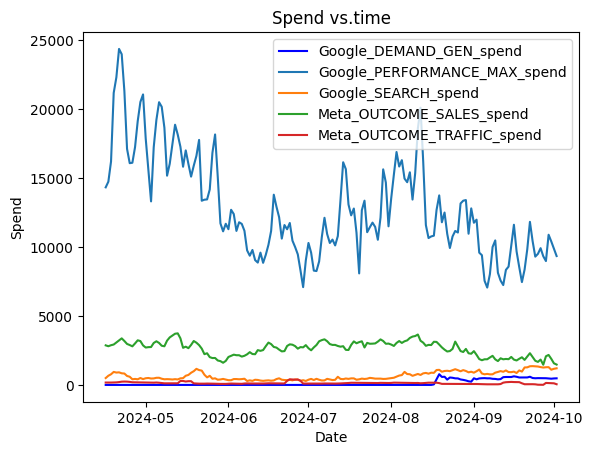

In [9]:
import matplotlib.pyplot as plt


plt.plot(df_final['stat_date'], df_final['Google_DEMAND_GEN_spend'], color='blue', label='Google_DEMAND_GEN_spend')
plt.plot(df_final['stat_date'], df_final['Google_PERFORMANCE_MAX_spend'], label='Google_PERFORMANCE_MAX_spend')
plt.plot(df_final['stat_date'], df_final['Google_SEARCH_spend'],  label='Google_SEARCH_spend')
plt.plot(df_final['stat_date'], df_final['Meta_OUTCOME_SALES_spend'], label='Meta_OUTCOME_SALES_spend')
plt.plot(df_final['stat_date'], df_final['Meta_OUTCOME_TRAFFIC_spend'], label='Meta_OUTCOME_TRAFFIC_spend')


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Spend')
plt.title('Spend vs.time')
plt.legend()

# Show the plot
plt.show()

In [11]:
feature_col = df_final[mdsp_cols].columns.to_list()
extra_feature_col = df_final[control_vars].columns.to_list()
extra_feature_col

['email_pv',
 'social_pv',
 'shopify_app_pv',
 'direct_pv',
 'season1',
 'season2',
 'TikTok_TRAFFIC_aov',
 'TikTok_WEB_CONVERSIONS_aov',
 'Meta_OUTCOME_APP_PROMOTION_aov',
 'Meta_OUTCOME_TRAFFIC_aov',
 'Google_SEARCH_aov',
 'Google_PERFORMANCE_MAX_aov',
 'Google_DEMAND_GEN_aov',
 'sum_sales_l3']

In [12]:
# Check for NaN or Inf after transformations
import numpy as np
media_data_transformed = media_scaler.transform(media_data)
extra_features_transformed = extra_features_scaler.transform(extra_features)
target_data_transformed = target_scaler.transform(target)

print("Checking media_data after transformation...")
print(np.isnan(media_data_transformed).sum())
print(np.isinf(media_data_transformed).sum())

print("Checking target_data after transformation...")
print(np.isnan(target_data_transformed).sum())
print(np.isinf(target_data_transformed).sum())

print("Checking extra_features_data after transformation...")
print(np.isnan(extra_features_transformed).sum())
print(np.isinf(extra_features_transformed).sum())


Checking media_data after transformation...
0
0
Checking target_data after transformation...
0
0
Checking extra_features_data after transformation...
0
0


# Check Correlations/ Variance/ spend pct

In [13]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features))

In [14]:
correlations[0]

,feature_0,feature_1,feature_2,feature_3,feature_4,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,extra_feature_4,extra_feature_5,extra_feature_6,extra_feature_7,extra_feature_8,extra_feature_9,extra_feature_10,extra_feature_11,extra_feature_12,extra_feature_13,target
feature_0,1.000000,-0.435416,0.770831,-0.582041,-0.324555,-0.044831,-0.099882,-0.182463,-0.086819,-0.039650,-0.114428,-0.035295,0.034743,0.061963,0.125902,-0.005974,0.029418,-0.098546,-0.341019,-0.324292
feature_1,-0.435416,1.000000,-0.098231,0.535600,0.296163,0.013089,0.032538,0.164379,0.031538,0.114043,0.072382,0.020398,-0.167189,-0.009237,0.007867,-0.043647,0.025890,0.177788,0.665248,0.625273
feature_2,0.770831,-0.098231,1.000000,-0.362901,-0.261271,-0.036787,-0.122794,-0.074171,-0.074509,0.030839,0.072324,-0.092667,-0.004833,0.069961,0.110364,0.006178,0.092881,0.045246,-0.021685,-0.036047
feature_3,-0.582041,0.535600,-0.362901,1.000000,0.390433,0.016129,0.063840,0.139957,0.021706,0.022160,0.050934,0.033449,0.047156,-0.114588,-0.032787,0.064205,0.071422,0.095422,0.610667,0.598967
feature_4,-0.324555,0.296163,-0.261271,0.390433,1.000000,0.090851,0.085905,0.021180,0.107651,-0.037888,-0.015651,0.002418,-0.073748,0.009369,0.042232,-0.024662,-0.115661,0.184801,0.203776,0.201094
extra_feature_0,-0.044831,0.013089,-0.036787,0.016129,0.090851,1.000000,0.155070,0.259843,-0.064496,0.006174,0.115299,-0.015424,0.065165,0.017669,0.182965,0.045381,-0.084807,-0.066619,-0.004819,0.014167
extra_feature_1,-0.099882,0.032538,-0.122794,0.063840,0.085905,0.155070,1.000000,0.115518,-0.044377,0.020454,-0.069843,-0.026081,0.042930,-0.105036,0.107539,-0.070401,0.054326,0.014776,0.016007,0.033625
extra_feature_2,-0.182463,0.164379,-0.074171,0.139957,0.021180,0.259843,0.115518,1.000000,-0.111925,-0.052898,0.095184,-0.024273,-0.108722,0.024220,0.055632,0.120206,0.035501,-0.069732,0.119456,0.124220
extra_feature_3,-0.086819,0.031538,-0.074509,0.021706,0.107651,-0.064496,-0.044377,-0.111925,1.000000,0.065860,0.112028,-0.081626,0.109401,-0.108620,-0.112505,-0.086994,-0.042295,-0.109216,0.027466,0.020613
extra_feature_4,-0.039650,0.114043,0.030839,0.022160,-0.037888,0.006174,0.020454,-0.052898,0.065860,1.000001,-0.083826,-0.057901,0.047189,-0.073507,-0.069059,-0.013772,-0.050365,0.011503,0.082809,0.132832


In [15]:
correlation_matrix = correlations[0]
high_corr = correlation_matrix.abs() > 0.7
high_corr_cols = correlation_matrix[high_corr]

high_corr_cols.columns = feature_col + extra_feature_col + ['sum_sales']
high_corr_cols.index = feature_col + extra_feature_col + ['sum_sales']

for idx, row in high_corr_cols.iterrows():
  corr = row[(row > 0.7) & (row < 0.99)].dropna()
  if not corr.empty:
    print(f"column {idx} has high corr with: {corr}")
    print("----------------------------------------")

column Google_DEMAND_GEN_spend has high corr with: Google_SEARCH_spend    0.770831
Name: Google_DEMAND_GEN_spend, dtype: float64
----------------------------------------
column Google_SEARCH_spend has high corr with: Google_DEMAND_GEN_spend    0.770831
Name: Google_SEARCH_spend, dtype: float64
----------------------------------------
column sum_sales_l3 has high corr with: sum_sales    0.922002
Name: sum_sales_l3, dtype: float64
----------------------------------------
column sum_sales has high corr with: sum_sales_l3    0.922002
Name: sum_sales, dtype: float64
----------------------------------------


In [16]:
def highlight_low_spend_fractions(x: float,
                                  low_spend_threshold: float=0.01) -> str:
    if x < low_spend_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

spend_fractions.index = feature_col
spend_fractions.style.format(precision=4).applymap(highlight_low_spend_fractions)

# spend_fractions[spend_fractions < 0.01].dropna(how='all')
spend_fractions_list = spend_fractions[spend_fractions < 0.01].dropna(how='all').index.to_list()
spend_fractions_list

<ipython-input-16-7dadac2656c7>:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  spend_fractions.style.format(precision=4).applymap(highlight_low_spend_fractions)


['Google_DEMAND_GEN_spend', 'Meta_OUTCOME_TRAFFIC_spend']

In [17]:
spend_fractions

,fraction of spend
Google_DEMAND_GEN_spend,0.0080
Google_PERFORMANCE_MAX_spend,0.7826
Google_SEARCH_spend,0.0405
Meta_OUTCOME_SALES_spend,0.1608
Meta_OUTCOME_TRAFFIC_spend,0.0081


In [18]:
def highlight_variances(x: float,
                        low_variance_threshold: float=1.0e-3,
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.index = feature_col + extra_feature_col
# variances.style.format(precision=4).applymap(highlight_variances)
filtered_variances = variances[(variances > 3.0) | (variances < 1.0e-3)].dropna(how='all')
filtered_variances_list = filtered_variances.index.to_list()
filtered_variances_list.remove('season1')
filtered_variances_list.remove('season2')
filtered_variances_list

['Google_DEMAND_GEN_spend',
 'TikTok_TRAFFIC_aov',
 'Meta_OUTCOME_APP_PROMOTION_aov',
 'Google_DEMAND_GEN_aov']

In [19]:
def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.index = feature_col + extra_feature_col
variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)
high_vif = variance_inflation_factors[variance_inflation_factors > 7.0].dropna(how='all')
high_vif_list = high_vif.index.to_list()
high_vif

<ipython-input-19-c87e22104bc2>:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)


,geo_0


# Run model with final variables

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


The 1 Eval:
Checking media_data after transformation...
0
0
Checking target_data after transformation...
0
0
Checking extra_features_data after transformation...
0
0


sample: 100%|██████████| 200/200 [02:07<00:00,  1.57it/s, 1023 steps of size 8.79e-03. acc. prob=0.99]


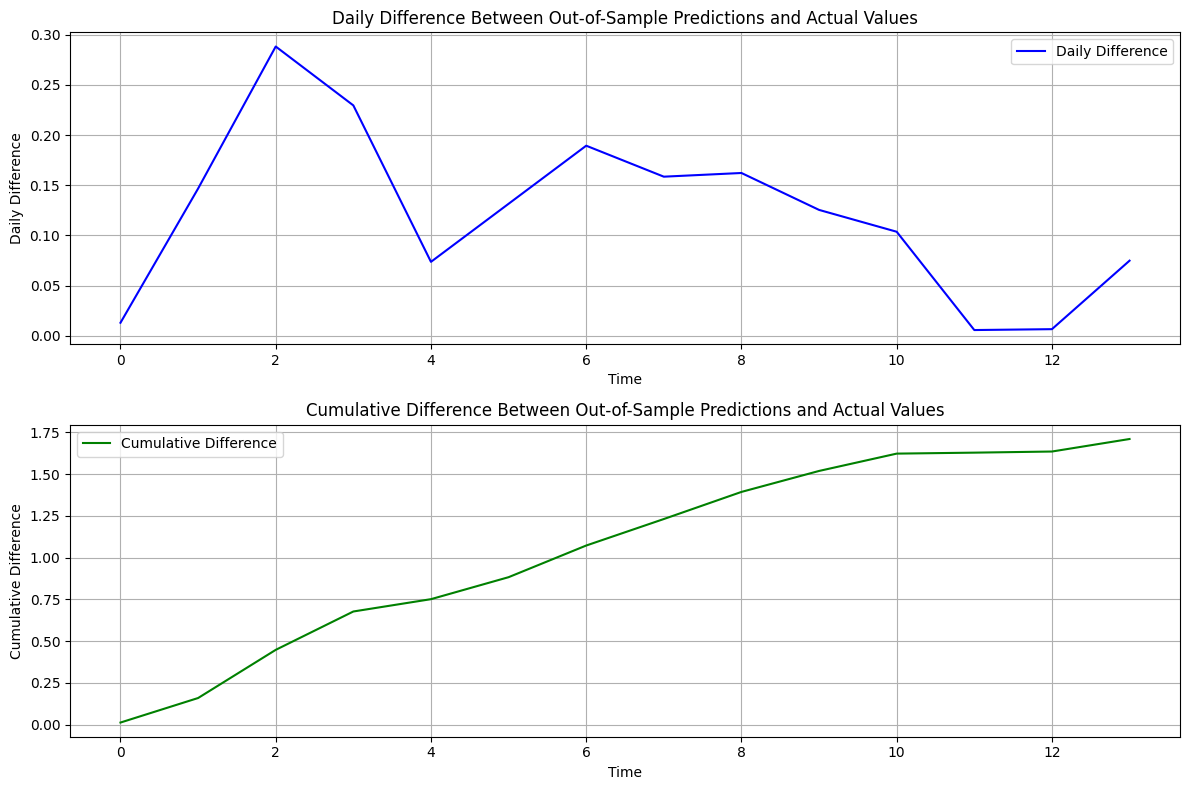

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import numpyro.distributions as dist

# drop variables that have few spending, high variance, high vif
drop_list = spend_fractions_list + filtered_variances_list + high_vif_list
df_final2 = df_final.drop(drop_list, axis = 1)

results = {}
predictions = {}
data_versions = {}
train_fig_dic = {}
test_fig_dic = {}

# evaluate 4 times
for i in range(4):
  if i == 0:
    df_final2 = df_final2.copy()

  else:
    df_final2 = df_final2[:-test_days]

  data_versions[f'df_final2_{i}'] = df_final2

  # Define custom scalers
  media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
  extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
  target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
  cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=1)

  # run the function to prepare data
  prepared_data2 = prepare_data_for_model(df_final2, 'sum_sales', test_days, media_scaler, extra_features_scaler,target_scaler, cost_scaler)

  media_data = prepared_data2['media_data']
  media_data_train = prepared_data2['media_data_train']
  media_data_test = prepared_data2['media_data_test']
  extra_features = prepared_data2['extra_features']
  extra_features_train = prepared_data2['extra_features_train']
  extra_features_test = prepared_data2['extra_features_test']
  target = prepared_data2['target']
  target_train = prepared_data2['target_train']
  costs = prepared_data2['costs']
  mdsp_cols = prepared_data2['mdsp_cols']
  control_vars = prepared_data2['control_vars']
  split_point = prepared_data2['split_point']

  print(f"The {i+1} Eval:")
  print("Checking media_data after transformation...")
  print(np.isnan(media_data_train).sum())
  print(np.isinf(media_data_train).sum())

  print("Checking target_data after transformation...")
  print(np.isnan(target_train).sum())
  print(np.isinf(target_train).sum())

  print("Checking extra_features_data after transformation...")
  print(np.isnan(extra_features_train).sum())
  print(np.isinf(extra_features_train).sum())

  # Media contribution priors
  channel_contribution_weights={'pmax':0.8,
                 'search':0.6,
                 'meta':0.2}
  mod_media_priors=jnp.array(list(channel_contribution_weights.values()))*costs

  # Media saturation priors
  media_concentration_weights={'pmax':1,
                 'search':0.1,
                 'meta':0.5}

  media_concentration_weights_priors=jnp.array(list(media_concentration_weights.values()))

  # Media adstock priors
  channel_adstock_weights={'pmax':1,
                 'search':0.5,
                 'meta':0.2}
  adstock_lag_weight_priors=jnp.array(list(channel_adstock_weights.values()))

  custom_priors = {
                 "lag_weight": numpyro.distributions.Beta(concentration1=adstock_lag_weight_priors, concentration0=jnp.ones(len(adstock_lag_weight_priors),)),
                 "half_max_effective_concentration": numpyro.distributions.Gamma(concentration=media_concentration_weights_priors, rate=jnp.ones(len(media_concentration_weights_priors),)),
                  "intercept": numpyro.distributions.HalfNormal(10),
                 "coef_extra_features": dist.Normal(0, 0.04)
                 }


  # choose one from hill_adstock, adstock, carryover
  mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

  # reuse the same seed for different trainings.
  SEED = 926
  mmm.fit(
      media=media_data_train,
      media_names = mdsp_cols,
      media_prior=mod_media_priors,
      target=target_train,
      extra_features=extra_features_train,
      # for daily data, use weekday_seasonality to add the effect of weekend
      weekday_seasonality = True,
      target_accept_prob = 0.8,
      number_chains=1,
      custom_priors=custom_priors,
      number_samples = 100,
      number_warmup = 100,
      seed=SEED)

  results[f'mmm_result_{i}'] = mmm

  current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

  #plot training results
  train_fig = plot.plot_model_fit(mmm, target_scaler=target_scaler)
  train_fig.savefig(f'/content/drive/MyDrive/MMM results/train_fig_{i}_{current_time}.png')
  train_fig_dic[f'train_fig_{i}'] = train_fig
  train_fig


  #Used trained model to predict
  new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)

  predictions[f'predictions_{i}'] = new_predictions

  # plot test results
  test_fig = plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))
  test_fig.savefig(f'/content/drive/MyDrive/MMM results/test_fig_{i}_{current_time}.png')
  test_fig_dic[f'test_fig_{i}'] = test_fig
  test_fig

  # Predicted result
  original_scale_predictions = target_scaler.inverse_transform(new_predictions)

  # Calculate the daily difference of Predicted result and real data
  daily_diff = (np.mean(original_scale_predictions, axis = 0) - target[split_point:])/target[split_point:]

  # Calculate the cumulative difference
  cumulative_diff = np.cumsum(daily_diff)

  # Plot both the daily difference and cumulative difference
  plt.figure(figsize=(12, 8))

  # Plot daily difference
  plt.subplot(2, 1, 1)
  plt.plot(daily_diff, label='Daily Difference', color='blue')
  plt.title('Daily Difference Between Out-of-Sample Predictions and Actual Values')
  plt.xlabel('Time')
  plt.ylabel('Daily Difference')
  plt.legend()
  plt.grid(True)

  plt.savefig(f"/content/drive/MyDrive/MMM results/daily_diff_plot_{i}_{current_time}.png")

  # Plot cumulative difference
  plt.subplot(2, 1, 2)
  plt.plot(cumulative_diff, label='Cumulative Difference', color='green')
  plt.title('Cumulative Difference Between Out-of-Sample Predictions and Actual Values')
  plt.xlabel('Time')
  plt.ylabel('Cumulative Difference')
  plt.legend()
  plt.grid(True)

  plt.savefig(f"/content/drive/MyDrive/MMM results/cumulative_diff_plot_{i}_{current_time}.png")

  plt.tight_layout()
  plt.show()

  break





In [22]:
# Check the training errors
# Actual train values
mmm = results[f'mmm_result_0']
actual_train_values = mmm._target

# Predicted (fitted) values from the model (posterior predictions)
predicted_train_values = mmm.trace["mu"]

actual_train_values = target_scaler.inverse_transform(actual_train_values)
predicted_train_values = np.mean(target_scaler.inverse_transform(predicted_train_values),axis = 0)

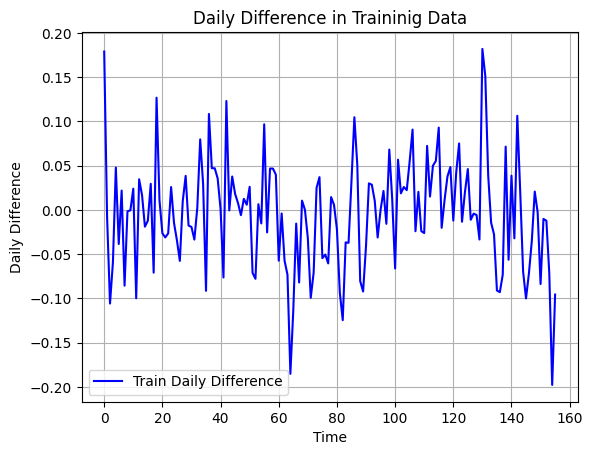

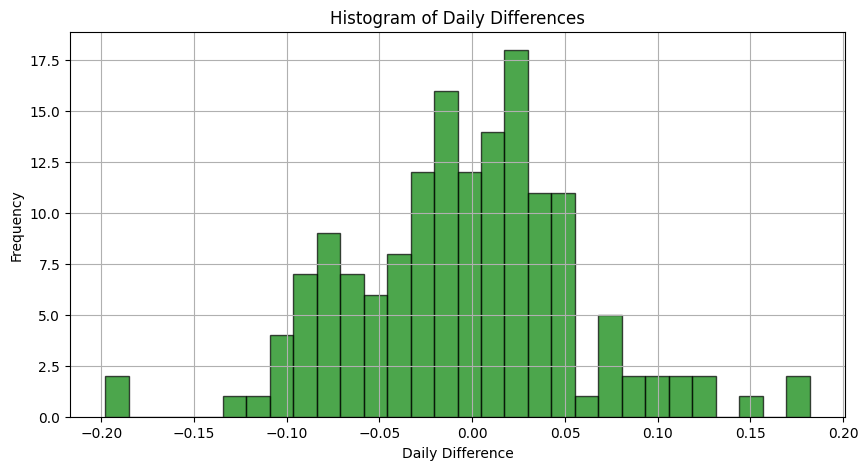

In [23]:
train_daily_diff = (actual_train_values - predicted_train_values)/ actual_train_values


plt.plot(train_daily_diff, label='Train Daily Difference', color='blue')
plt.title('Daily Difference in Traininig Data')
plt.xlabel('Time')
plt.ylabel('Daily Difference')
plt.legend()
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.hist(train_daily_diff.flatten(), bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Histogram of Daily Differences')
plt.xlabel('Daily Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [30]:
mmm = results['mmm_result_0']

In [31]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

In [32]:
df_con = pd.DataFrame(media_contribution, columns=mdsp_cols)
df_con_agg = df_con.copy()

performance_max_cols = [col for col in df_con_agg.columns if 'PERFORMANCE_MAX' in col]
df_con_agg['Google_pmax'] = df_con_agg[performance_max_cols].sum(axis=1)


search_cols = [col for col in df_con_agg.columns if 'SEARCH' in col]
df_con_agg['Google_search'] = df_con_agg[search_cols].sum(axis=1)

meta_cols = [col for col in df_con_agg.columns if 'Meta' in col]
df_con_agg['Meta_sum'] = df_con_agg[meta_cols].sum(axis=1)
df_con_agg.describe()


,Google_PERFORMANCE_MAX_spend,Google_SEARCH_spend,Meta_OUTCOME_SALES_spend,Google_pmax,Google_search,Meta_sum
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.485001,0.030318,0.078959,0.485001,0.030318,0.078959
std,0.161762,0.026079,0.038665,0.161762,0.026079,0.038665
min,0.223606,0.001184,0.015916,0.223606,0.001184,0.015916
25%,0.357794,0.012169,0.050736,0.357794,0.012169,0.050736
50%,0.449055,0.024105,0.071555,0.449055,0.024105,0.071555
75%,0.600037,0.041900,0.100055,0.600037,0.041900,0.100055
max,0.925668,0.142500,0.242130,0.925668,0.142500,0.242130


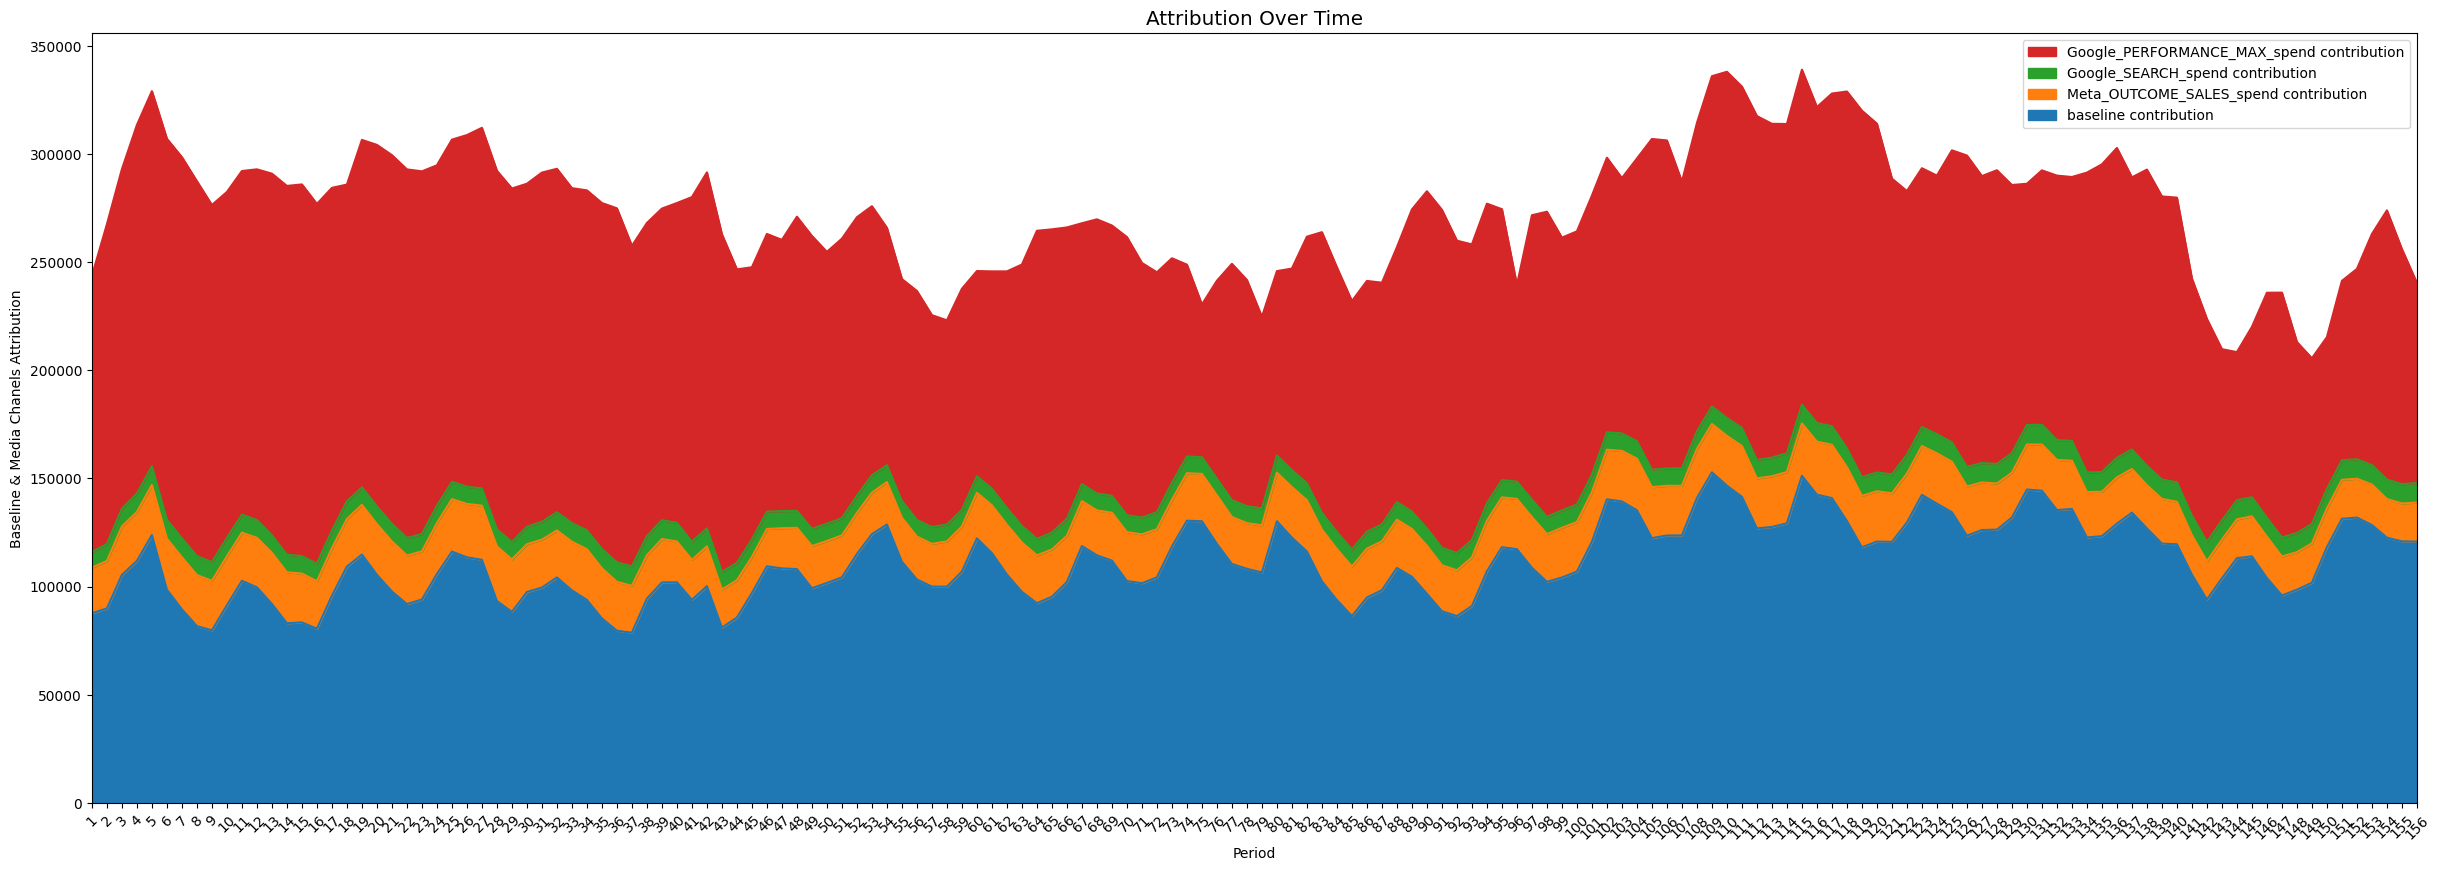

In [33]:
channel_names = mdsp_cols

plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                channel_names=channel_names,
                                                fig_size=(30,10))

In [34]:
pd.DataFrame({'channels':channel_names, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

,channels,adstock_decay
0,Google_PERFORMANCE_MAX_spend,0.180099
1,Google_SEARCH_spend,0.394912
2,Meta_OUTCOME_SALES_spend,0.114722


In [35]:
contribution_df = plot.create_media_baseline_contribution_df(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                channel_names=channel_names)
contribution_df.tail()

,Google_PERFORMANCE_MAX_spend_percentage,Google_SEARCH_spend_percentage,Meta_OUTCOME_SALES_spend_percentage,baseline_percentage,avg_prediction,Google_PERFORMANCE_MAX_spend contribution,Google_SEARCH_spend contribution,Meta_OUTCOME_SALES_spend contribution,baseline contribution,period
151,0.356344,0.036420,0.072768,0.534469,246848.96875,87963.062500,8990.165039,17962.732422,131933.015625,152
152,0.406209,0.034126,0.071074,0.488591,263006.65625,106835.789062,8975.326172,18692.832031,128502.703125,153
153,0.454252,0.032804,0.065263,0.447681,273937.96875,124436.781250,8986.247070,17877.988281,122636.960938,154
154,0.424300,0.034907,0.068438,0.472355,256016.00000,108627.570312,8936.785156,17521.291016,120930.367188,155
155,0.384785,0.037506,0.075091,0.502618,240383.43750,92495.851562,9015.916992,18050.601562,120821.078125,156


In [36]:
media_coefficients = jnp.mean(mmm.trace['coef_media'], axis=0)
extra_features_coefficients = jnp.mean(mmm.trace['coef_extra_features'], axis=0)

#media channel coefficients with 95% CI
media_posteriors = mmm.trace['coef_media']
for i, (media_channel, name) in enumerate(zip(media_posteriors.T, mdsp_cols)):
    mean_coef = np.mean(media_channel)
    lower_bound = np.percentile(media_channel, 2.5)
    upper_bound = np.percentile(media_channel, 97.5)

    print(f"{name}: Mean Coef = {mean_coef:.3f}, 95% CI = [{lower_bound:.3f}, {upper_bound:.3f}]")

# extra feature coefficients with 95% CI
extra_features_posteriors = mmm.trace['coef_extra_features']
for i, extra_feature in enumerate(extra_features_posteriors.T):
    mean_coef = np.mean(extra_feature)
    lower_bound = np.percentile(extra_feature, 2.5)
    upper_bound = np.percentile(extra_feature, 97.5)

    print(f"Non-Ads Channel {i+1}: Mean Coef = {mean_coef:.3f}, 95% CI = [{lower_bound:.3f}, {upper_bound:.3f}]")


Google_PERFORMANCE_MAX_spend: Mean Coef = 0.691, 95% CI = [0.389, 1.169]
Google_SEARCH_spend: Mean Coef = 0.047, 95% CI = [0.004, 0.140]
Meta_OUTCOME_SALES_spend: Mean Coef = 0.142, 95% CI = [0.056, 0.266]
Non-Ads Channel 1: Mean Coef = 0.002, 95% CI = [-0.013, 0.021]
Non-Ads Channel 2: Mean Coef = 0.015, 95% CI = [-0.010, 0.034]
Non-Ads Channel 3: Mean Coef = -0.009, 95% CI = [-0.046, 0.026]
Non-Ads Channel 4: Mean Coef = -0.005, 95% CI = [-0.031, 0.026]
Non-Ads Channel 5: Mean Coef = 0.002, 95% CI = [-0.000, 0.004]
Non-Ads Channel 6: Mean Coef = 0.005, 95% CI = [-0.000, 0.010]
Non-Ads Channel 7: Mean Coef = 0.002, 95% CI = [-0.003, 0.007]
Non-Ads Channel 8: Mean Coef = -0.000, 95% CI = [-0.018, 0.018]
Non-Ads Channel 9: Mean Coef = 0.011, 95% CI = [-0.056, 0.068]
Non-Ads Channel 10: Mean Coef = 0.008, 95% CI = [-0.070, 0.079]
Non-Ads Channel 11: Mean Coef = 0.147, 95% CI = [0.086, 0.215]


In [37]:
train_df = df_final[:-test_days][['stat_date','Google_PERFORMANCE_MAX_spend','Google_SEARCH_spend','Meta_OUTCOME_SALES_spend']].reset_index(drop = True)

roas_curve_df = pd.concat([train_df,contribution_df],axis = 1)
roas_curve_df

,stat_date,Google_PERFORMANCE_MAX_spend,Google_SEARCH_spend,Meta_OUTCOME_SALES_spend,Google_PERFORMANCE_MAX_spend_percentage,Google_SEARCH_spend_percentage,Meta_OUTCOME_SALES_spend_percentage,baseline_percentage,avg_prediction,Google_PERFORMANCE_MAX_spend contribution,Google_SEARCH_spend contribution,Meta_OUTCOME_SALES_spend contribution,baseline contribution,period
0,2024-04-16,14322.412373,497.805136,2868.420308,0.524134,0.029409,0.086583,0.359874,243645.140625,127702.710938,7165.286133,21095.513672,87681.640625,1
1,2024-04-17,14734.239386,666.339332,2804.496144,0.552476,0.029329,0.081943,0.336251,267508.437500,147792.078125,7845.855469,21920.515625,89949.984375,2
2,2024-04-18,16197.742535,772.618817,2878.858612,0.535700,0.027990,0.076355,0.359955,292989.093750,156954.187500,8200.849609,22371.169922,105462.890625,3
3,2024-04-19,21168.489840,942.276350,2928.239075,0.543637,0.027113,0.072153,0.357097,313399.937500,170375.718750,8497.288086,22612.683594,111914.242188,4
4,2024-04-20,22297.230739,896.367415,3074.740360,0.527070,0.026207,0.070245,0.376478,329044.593750,173429.625000,8623.228516,23113.775391,123877.976562,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2024-09-14,8577.211863,931.102238,1865.994859,0.356344,0.036420,0.072768,0.534469,246848.968750,87963.062500,8990.165039,17962.732422,131933.015625,152
152,2024-09-15,10114.405408,926.613690,2028.681234,0.406209,0.034126,0.071074,0.488591,263006.656250,106835.789062,8975.326172,18692.832031,128502.703125,153
153,2024-09-16,11610.505878,960.952568,1834.408740,0.454252,0.032804,0.065263,0.447681,273937.968750,124436.781250,8986.247070,17877.988281,122636.960938,154
154,2024-09-17,9676.075221,864.529421,1772.524422,0.424300,0.034907,0.068438,0.472355,256016.000000,108627.570312,8936.785156,17521.291016,120930.367188,155


In [38]:
import plotly.express as px

ad_type_list = ['PERFORMANCE_MAX', 'SEARCH', 'OUTCOME_SALES']

for i in ad_type_list:
  matched_col = [col for col in roas_curve_df.columns if i in col]
  print(matched_col)

  ads_spend = matched_col[0]
  ads_roas = roas_curve_df[matched_col[2]]/ roas_curve_df[matched_col[0]]

  fig = px.scatter(roas_curve_df, x = ads_spend, y = ads_roas)

  fig.show()

['Google_PERFORMANCE_MAX_spend', 'Google_PERFORMANCE_MAX_spend_percentage', 'Google_PERFORMANCE_MAX_spend contribution']


['Google_SEARCH_spend', 'Google_SEARCH_spend_percentage', 'Google_SEARCH_spend contribution']


['Meta_OUTCOME_SALES_spend', 'Meta_OUTCOME_SALES_spend_percentage', 'Meta_OUTCOME_SALES_spend contribution']


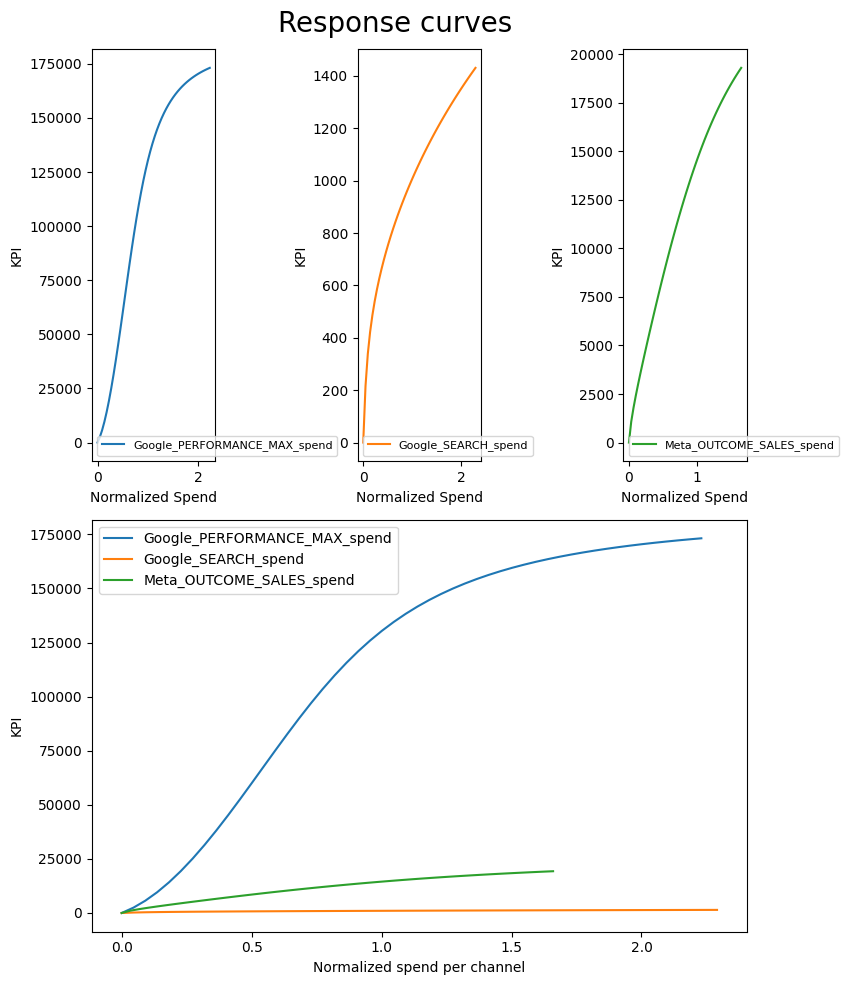

In [39]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

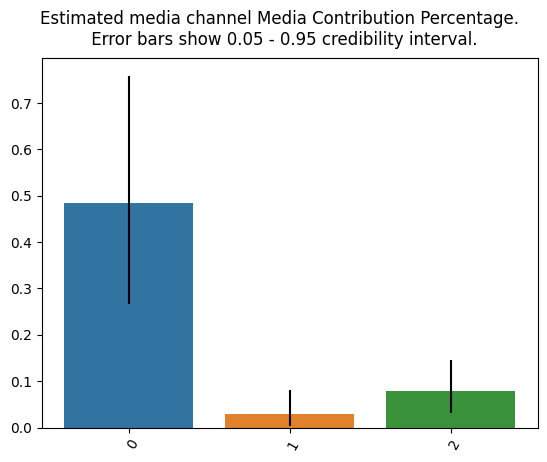

In [40]:

plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")